In [1]:
#Code by: Danish Zaheer
#Date: 17-10-2022

#importing all required libraries
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

### **Problem 2.1:**

Use Ridge regression to solve the regression problem in Example 2.1 as well as the classification problem in Example 2.2, also implement both closed-form and iterative approachs, compare the results of Ridge regression with those of linear regression.

In [2]:
#importing data
raw_data = pd.read_csv('boston.csv', header=None)
#reshaping raw data
data_rows = np.reshape(raw_data.to_numpy(), (506,14))
#separating features
data = data_rows[:,:13]
#separting output
target = data_rows[:,13]
# normalize input features to zero-mean and unit-variance
data = (data-np.mean(data, axis=0))/np.std(data, axis=0) 
print(data.shape)
print(target.shape)

(506, 13)
(506,)



**Implementing closed-form**
Ridge regression = (XTX+λI)^−1(XTy).

In [3]:
# add a constant column of '1' to accomodate the bias 
data_wb = np.hstack((data, np.ones((data.shape[0], 1), dtype=data.dtype)))
I = np.eye(data_wb.shape[1])
I[0][0] = 0 
alpha = 1
#closed-form solution
w = np.linalg.inv(data_wb.T @ data_wb + alpha*I) @ data_wb.T @ target
# calculate the mean square error in the training set
predict = data_wb @ w 
error = np.sum((predict - target)*(predict - target))/data.shape[0]
e1 = error #for further comparison
print(f'Mean square error for the closed-form Ridge regression solution: {error:.5f}')

Mean square error for the closed-form Ridge regression solution: 21.89781


**Implementing Iterative Ridge regression**

In [4]:
# Ridge Regression(alternative function for testing purpose)
class RidgeRegression():
    def __init__(self, learning_rate, iterations, L2_penality):  
        self.learning_rate = learning_rate        
        self.iterations = iterations        
        self.L2_penality = L2_penality
    # Function for model training            
    def fit(self, X, Y ):
        # no_of_training_examples, no_of_features        
        self.m, self.n = X.shape
        # weight initialization        
        self.W = np.zeros( self.n)
        self.b = 0        
        self.X = X        
        self.Y = Y
        # gradient descent learning
        for i in range(self.iterations):            
            self.update_weights()            
        return self
    # Helper function to update weights in gradient descent
    def update_weights(self):           
        Y_pred = self.predict(self.X)
        # calculate gradients
        dW = (-(2*(self.X.T).dot(self.Y - Y_pred)) + (2*self.L2_penality*self.W))/self.m     
        db = -2*np.sum(self.Y - Y_pred)/self.m 
        # update weights    
        self.W = self.W - self.learning_rate * dW    
        self.b = self.b - self.learning_rate * db        
        return self
    # Hypothetical function  h( x ) 
    def predict(self, X) :    
        return X.dot( self.W ) + self.b

In [5]:
# solve ridge regression using gradient descent 
class Optimizer():
    def __init__(self, lr, alpha, annealing_rate, batch_size, max_epochs):
        self.lr = lr
        self.alpha = alpha
        self.annealing_rate = annealing_rate
        self.batch_size = batch_size
        self.max_epochs = max_epochs

# X[N,d]: input features; y[N]: output targets; op: hyper-parameters for optimzer 
def ridge_regression_gd(X, y, op):
    n = X.shape[0]   # number of samples
    w = np.zeros(X.shape[1])  # initialization
    lr = op.lr
    errors = np.zeros(op.max_epochs)
    
    for epoch in range(op.max_epochs):
        indices = np.random.permutation(n)  #randomly shuffle data indices
        for batch_start in range(0, n, op.batch_size):
            X_batch = X[indices[batch_start:batch_start + op.batch_size]]
            y_batch = y[indices[batch_start:batch_start + op.batch_size]]
            
            # vectorization to compute gradients for a whole mini-batch (see the above formula)
            w_grad = (-2/y_batch.size)*X_batch.T.dot((y_batch - X_batch@w)) + op.alpha*w 
            
            w -= lr * w_grad / X_batch.shape[0]
        diff = X @ w - y  # prediction difference
        errors[epoch] = np.sum(diff*diff)/n
        lr *= op.annealing_rate
        #print(f'epoch={epoch}: the mean square error is {errors[epoch]}')
        
    return w, errors

Mean squared error Iterative Ridge regression: 79.05271


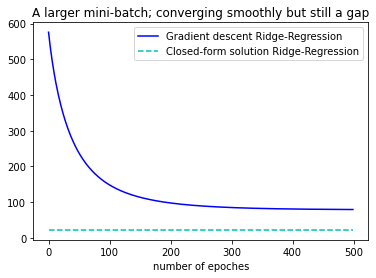

In [6]:
# hyperparameters
op = Optimizer(lr=0.01, alpha=0.01, annealing_rate=0.99, batch_size=30 , max_epochs=500)
w, errors = ridge_regression_gd(data_wb, target, op)
#Training the model
predict = data_wb @ w
#predicting MSE
print("Mean squared error Iterative Ridge regression: %.5f" % mean_squared_error(target, predict))

#Plotting the graph for above case
plt.title('A larger mini-batch; converging smoothly but still a gap')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['Gradient descent Ridge-Regression', 'Closed-form solution Ridge-Regression'])

Mean squared error Iterative Ridge regression: 22.02725


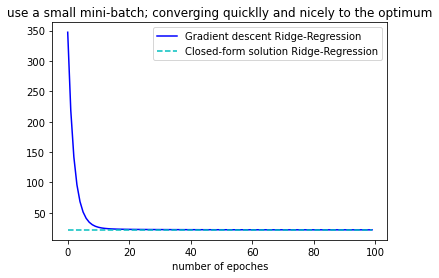

In [7]:
# hyperparameters
op = Optimizer(lr=0.001, alpha=0.01, annealing_rate=0.99, batch_size=2 , max_epochs=100)
w, errors = ridge_regression_gd(data_wb, target, op)
#Training the model
predict = data_wb @ w
#predicting MSE
print("Mean squared error Iterative Ridge regression: %.5f" % mean_squared_error(target, predict))

#Plotting the graph for above case
plt.title('use a small mini-batch; converging quicklly and nicely to the optimum')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['Gradient descent Ridge-Regression', 'Closed-form solution Ridge-Regression'])

Mean squared error Iterative Ridge regression: 23.34560


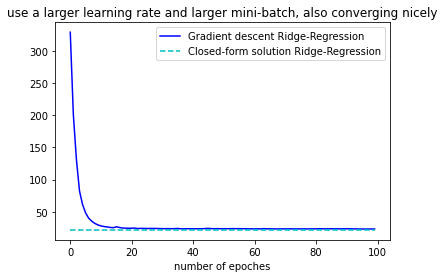

In [8]:
# hyperparameters
op = Optimizer(lr=0.1, alpha=0.1, annealing_rate=0.99, batch_size=20 , max_epochs=100)
w, errors = ridge_regression_gd(data_wb, target, op)
#Training the model
predict = data_wb @ w
#predicting MSE
print("Mean squared error Iterative Ridge regression: %.5f" % mean_squared_error(target, predict))

#Plotting the graph for above case
plt.title('use a larger learning rate and larger mini-batch, also converging nicely')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['Gradient descent Ridge-Regression', 'Closed-form solution Ridge-Regression'])

Mean squared error Iterative Ridge regression: 30.68776


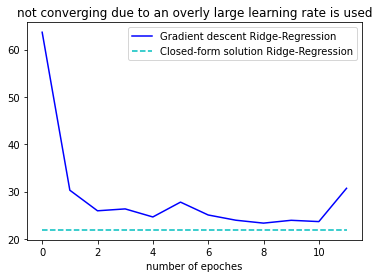

In [9]:
# hyperparameters
op = Optimizer(lr=0.5, alpha=0.1, annealing_rate=0.99, batch_size=20 , max_epochs=12)
w, errors = ridge_regression_gd(data_wb, target, op)
#Training the model
predict = data_wb @ w
#predicting MSE
print("Mean squared error Iterative Ridge regression: %.5f" % mean_squared_error(target, predict))

#Plotting the graph for above case
plt.title('not converging due to an overly large learning rate is used')
plt.xlabel('number of epoches')
plt.plot(errors, 'b', 21.89*np.ones(errors.shape[0]), 'c--')
plt.legend(['Gradient descent Ridge-Regression', 'Closed-form solution Ridge-Regression'])

In [10]:
#For testing purpose please ignore

# hyperparameters
#op = RidgeRegression(iterations = 1000, learning_rate = 0.01, L2_penality = 1)
#Training the model
#op.fit( data_wb, target)
#predict = op.predict(data_wb)
#predicting MSE
#print("Mean squared error Iterative Ridge regression: %.5f" % mean_squared_error(target, predict))

In [11]:
# Comparison with Linear regression using scikit learn

# Create linear regression object
l_regr = linear_model.LinearRegression()
# Train the model using the training set
l_regr.fit(data_wb, target)
# Make predictions using the same training set
predict = l_regr.predict(data_wb)
# The mean squared error
print("Mean squared error for linear regression: %.5f" % mean_squared_error(target, predict))

# Using Ridge regression Scikit learn
l_Ridge = linear_model.Ridge(alpha = 1)
# Train the model using the training set
l_Ridge.fit(data_wb, target)
# Make predictions using the same training set
predict = l_Ridge.predict(data_wb)
# The mean squared error
print("Mean squared error for Ridge regression: %.5f" % mean_squared_error(target, predict))

Mean squared error for linear regression: 21.89483
Mean squared error for Ridge regression: 21.89586


**Solving Example 2.2**

In [12]:
from mnist import MNIST

mnist_loader = MNIST('MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data, dtype='float')/255 # norm to [0,1]
train_label = np.array(train_label, dtype='short')
test_data = np.array(test_data, dtype='float')/255 # norm to [0,1]
test_label = np.array(test_label, dtype='short')
#add small random noise to avoid matrix singularity
train_data += np.random.normal(0,0.0001,train_data.shape) 
print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [13]:
# prepare digits '3' and '8' for Ridge regression
digit_train_index = np.logical_or(train_label == 3, train_label == 8)
X_train = train_data[digit_train_index]
y_train = train_label[digit_train_index]
digit_test_index = np.logical_or(test_label == 3, test_label == 8)
X_test = test_data[digit_test_index]
y_test = test_label[digit_test_index]
# add a constant column of '1' to accomodate the bias
X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1), dtype=X_train.dtype)))
X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1), dtype=X_test.dtype)))
# convert labels: '3' => -1, '8' => +1
CUTOFF = 5 # any number between '3' and '8'
y_train = np.sign(y_train-CUTOFF)
y_test = np.sign(y_test-CUTOFF)
print(X_train.shape)
print(y_train)
print(X_test.shape)
print(y_test)

(11982, 785)
[-1 -1 -1 ...  1 -1  1]
(1984, 785)
[-1 -1 -1 ... -1  1 -1]


**Solving by Closed-form**

In [14]:
# use the Ridge regression closed-form solution
I = np.eye(X_train.shape[1])
I[0][0] = 0 
alpha = 1
# refer to the closed-form solution
w = np.linalg.inv(X_train.T @ X_train + alpha*I) @ X_train.T @ y_train
# calculate the mean square error and Ridge regression accuracy on the training set
predict = X_train @ w 
error = np.sum((predict - y_train)*(predict - y_train))/X_train.shape[0]
print(f'Mean square error on training data for the closed-form Ridge regression solution: {error:.5f}')
accuracy = np.count_nonzero(np.equal(np.sign(predict),y_train))/y_train.size*100.0
print(f'Ridge regression accuracy on training data for the closed-form solution: {accuracy:.5f}%')

# calculate the mean square error and Ridge regression accuracy on the test set
predict = X_test @ w 
error = np.sum((predict - y_test)*(predict - y_test))/X_test.shape[0]
print(f'Mean square error on test data for the closed-form Ridge regression solution: {error:.5f}')
accuracy = np.count_nonzero(np.equal(np.sign(predict),y_test))/y_test.size*100.0
print(f'Ridge regression accuracy on test data for the closed-form solution: {accuracy:.5f}%')

Mean square error on training data for the closed-form Ridge regression solution: 0.20013
Ridge regression accuracy on training data for the closed-form solution: 96.78685%
Mean square error on test data for the closed-form Ridge regression solution: 0.22012
Ridge regression accuracy on test data for the closed-form solution: 96.01815%


**Solving by Iterative Manner**

In [15]:
# solve ridge regression using gradient descent 
class Optimizer():
    def __init__(self, lr, alpha, annealing_rate, batch_size, max_epochs):
        self.lr = lr
        self.alpha = alpha
        self.annealing_rate = annealing_rate
        self.batch_size = batch_size
        self.max_epochs = max_epochs

# X[N,d]: input features; y[N]: output targets; op: hyper-parameters for optimzer 
def ridge_regression_gd2(X, y, X2, y2, op):
    n = X.shape[0]   # number of samples
    w = np.zeros(X.shape[1])  # initialization
    lr = op.lr
    errorsA = np.zeros(op.max_epochs)
    errorsB = np.zeros(op.max_epochs)
    errorsC = np.zeros(op.max_epochs)
    for epoch in range(op.max_epochs):
        indices = np.random.permutation(n)  #randomly shuffle data indices
        for batch_start in range(0, n, op.batch_size):
            X_batch = X[indices[batch_start:batch_start + op.batch_size]]
            y_batch = y[indices[batch_start:batch_start + op.batch_size]]
            # vectorization to compute gradients for a whole mini-batch (see the above formula)
            # The gradient equations changed for Ridge regression  
            w_grad = (-2/y_batch.size)*X_batch.T.dot((y_batch - X_batch @w)) + op.alpha*w 
            w -= lr * w_grad / X_batch.shape[0]
        
        diff = X @ w - y  # prediction difference
        errorsC[epoch] = np.sum(diff*diff)/n
        
        # for learning curve A
        predict = np.sign(X @ w)
        errorsA[epoch] = np.count_nonzero(np.equal(predict,y))/y.size 
        # for learning curve B
        predict2 = np.sign(X2 @ w)
        errorsB[epoch] = np.count_nonzero(np.equal(predict2,y2))/y2.size
        lr *= op.annealing_rate
        print(f'epoch={epoch}: the mean square error is {errorsC[epoch]:.3f} ({errorsA[epoch]:.3f},{errorsB[epoch]:.3f})')
    return w, errorsA, errorsB, errorsC


epoch=0: the mean square error is 0.601 (0.896,0.906)
epoch=1: the mean square error is 0.443 (0.907,0.917)
epoch=2: the mean square error is 0.372 (0.916,0.926)
epoch=3: the mean square error is 0.334 (0.923,0.935)
epoch=4: the mean square error is 0.312 (0.929,0.941)
epoch=5: the mean square error is 0.297 (0.933,0.945)
epoch=6: the mean square error is 0.286 (0.937,0.950)
epoch=7: the mean square error is 0.278 (0.940,0.953)
epoch=8: the mean square error is 0.272 (0.942,0.955)
epoch=9: the mean square error is 0.266 (0.943,0.957)
epoch=10: the mean square error is 0.262 (0.945,0.957)
epoch=11: the mean square error is 0.259 (0.946,0.958)
epoch=12: the mean square error is 0.256 (0.948,0.958)
epoch=13: the mean square error is 0.253 (0.949,0.959)
epoch=14: the mean square error is 0.251 (0.950,0.960)
epoch=15: the mean square error is 0.249 (0.951,0.961)
epoch=16: the mean square error is 0.247 (0.952,0.962)
epoch=17: the mean square error is 0.246 (0.952,0.962)
epoch=18: the mean s

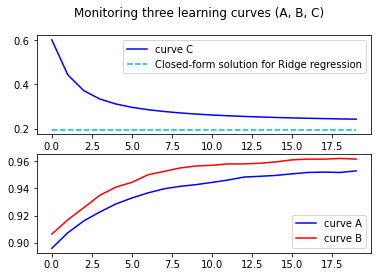

In [16]:
#hyperparameters
op = Optimizer(lr=0.01, alpha=0.1, annealing_rate=0.99, batch_size=50, max_epochs=20)
w, A, B, C = ridge_regression_gd2(X_train, y_train, X_test, y_test, op)
#predicting for training data
predict1 = X_train @ w
#MSE for #MSE for training data
print("Mean square error on training data for the Iterative Ridge regression solution: %.5f" % mean_squared_error(y_train, predict1))
#predicting for testing data
predict2 = X_test @ w
#MSE for testing data
print("Mean square error on test data for the Iterative Ridge regression solution: %.5f" % mean_squared_error(y_test, predict2))

#plotting the results
fig, ax = plt.subplots(2)
fig.suptitle('Monitoring three learning curves (A, B, C)')
ax[0].plot(C, 'b', 0.196*np.ones(C.shape[0]), 'c--')
ax[0].legend(['curve C', 'Closed-form solution for Ridge regression'])
ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

epoch=0: the mean square error is 0.264 (0.944,0.957)
epoch=1: the mean square error is 0.245 (0.953,0.963)
epoch=2: the mean square error is 0.234 (0.957,0.964)
epoch=3: the mean square error is 0.229 (0.959,0.963)
epoch=4: the mean square error is 0.226 (0.959,0.964)
epoch=5: the mean square error is 0.224 (0.960,0.963)
epoch=6: the mean square error is 0.234 (0.957,0.959)
epoch=7: the mean square error is 0.222 (0.960,0.964)
epoch=8: the mean square error is 0.223 (0.960,0.964)
epoch=9: the mean square error is 0.220 (0.961,0.964)
Mean square error on training data for the Iterative Ridge regression solution: 0.22000
Mean square error on test data for the Iterative Ridge regression solution: 0.21191


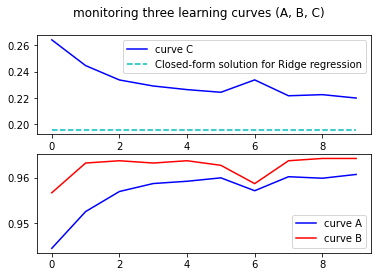

In [17]:
#hyperparameters
op = Optimizer(lr=0.001, alpha=0.1, annealing_rate=0.99, batch_size=5, max_epochs=10)
w, A, B, C = ridge_regression_gd2(X_train, y_train, X_test, y_test, op)
#predicting for training data
predict1 = X_train @ w
#MSE for #MSE for training data
print("Mean square error on training data for the Iterative Ridge regression solution: %.5f" % mean_squared_error(y_train, predict1))
#predicting for testing data
predict2 = X_test @ w
#MSE for testing data
print("Mean square error on test data for the Iterative Ridge regression solution: %.5f" % mean_squared_error(y_test, predict2))

#plotting the results
fig, ax = plt.subplots(2)
fig.suptitle('monitoring three learning curves (A, B, C)')
ax[0].plot(C, 'b', 0.196*np.ones(C.shape[0]), 'c--')
ax[0].legend(['curve C', 'Closed-form solution for Ridge regression'])
ax[1].plot(A, 'b', B, 'r')
ax[1].legend(['curve A', 'curve B'])

In [18]:
#for testing purpose please ignore the block

#hyperparameters
#op = RidgeRegression(iterations = 1000, learning_rate = 0.01, L2_penality = 2)
#training model
#op.fit(X_train, y_train)
#predicting for training data
#predict1 = op.predict(X_train)
#MSE for #MSE for testing data
#print("Mean square error on training data for the Iterative Ridge regression solution: %.5f" % mean_squared_error(y_train, predict1))
#predicting for testing data
#predict2 = op.predict(X_test)
#MSE for testing data
#print("Mean square error on test data for the Iterative Ridge regression solution: %.5f" % mean_squared_error(y_test, predict2))

In [19]:
# Comparison with Linear regression using scikit learn

# Create linear regression object
l_regr = linear_model.LinearRegression()
# Train the model using the training set
l_regr.fit(X_train, y_train)
# Make predictions using the same training set
predict1 = l_regr.predict(X_train)
print("Mean squared error on training data for Linear regression: %.5f" % mean_squared_error(y_train, predict1))
# Make predictions using the test set
predict2 = l_regr.predict(X_test)
print("Mean squared error on test data for Linear regression: %.5f" % mean_squared_error(y_test, predict2))

# Create Ridge regression object
Ridge = linear_model.Ridge()
# Train the model using the training set
Ridge.fit(X_train, y_train)
# Make predictions using the same training set
predict3 = Ridge.predict(X_train)
print("Mean squared error on training data for Ridge regression: %.5f" % mean_squared_error(y_train, predict3))
# Make predictions using the test set
predict4 = Ridge.predict(X_test)
print("Mean squared error on test data for Ridge regression: %.5f" % mean_squared_error(y_test, predict4))

Mean squared error on training data for Linear regression: 0.19626
Mean squared error on test data for Linear regression: 0.84347
Mean squared error on training data for Ridge regression: 0.20013
Mean squared error on test data for Ridge regression: 0.22013


### **Problem 2.2:**

Use LASSO to solve the regression problem in Example 2.1 as well as the classification problem in Example 2.2, compare the results of LASSO with those of linear regression and Ridge regression.

**Example 2.1**

In [20]:
# Create lasso regression object
lasso = linear_model.Lasso(alpha = 1)
# Make predictions using the training set
lasso.fit(data_wb, target)
# Make predictions using the same training set
predict = lasso.predict(data_wb)
# The mean squared error
print("Mean squared error: %.5f" % mean_squared_error(target, predict))

Mean squared error: 28.46465


In [21]:
# Comparison with Linear regression

# Create lasso regression object
lasso = linear_model.Lasso(alpha = 1)
# Make predictions using the training set
lasso.fit(data_wb, target)
# Make predictions using the same training set
predict = lasso.predict(data_wb)
# The mean squared error
print("Mean squared error for Lasso regression: %.5f" % mean_squared_error(target, predict))

# Create linear regression object
l_regr = linear_model.LinearRegression()
# Train the model using the training set
l_regr.fit(data_wb, target)
# Make predictions using the same training set
predict = l_regr.predict(data_wb)
# The mean squared error
print("Mean squared error for linear regression: %.5f" % mean_squared_error(target, predict))

Mean squared error for Lasso regression: 28.46465
Mean squared error for linear regression: 21.89483


In [22]:
# Comparison with Ridge regression 

# Create lasso regression object
lasso = linear_model.Lasso(alpha = 1)
# Make predictions using the training set
lasso.fit(data_wb, target)
# Make predictions using the same training set
predict = lasso.predict(data_wb)
# The mean squared error
print("Mean squared error for Lasso regression: %.5f" % mean_squared_error(target, predict))

# Using Ridge regression 
l_Ridge = linear_model.Ridge(alpha = 1)
# Train the model using the training set
l_Ridge.fit(data_wb, target)
# Make predictions using the same training set
predict = l_Ridge.predict(data_wb)
# The mean squared error
print("Mean squared error for Ridge regression: %.5f" % mean_squared_error(target, predict))

Mean squared error for Lasso regression: 28.46465
Mean squared error for Ridge regression: 21.89586


**Example 2.2**

In [23]:
# Create lasso regression object
lasso = linear_model.Lasso(alpha = 1)
# Train the model using the training set
lasso.fit(X_train,y_train)
# Make predictions using the training set
predict1 = lasso.predict(X_train)
#MSE for training data
print("Mean squared error on training data solution: %.5f" % mean_squared_error(y_train, predict1))
# Make predictions using the testing set
predict2 = lasso.predict(X_test)
#MSE for testing data
print("Mean squared error on test data solution: %.5f" % mean_squared_error(y_test, predict2))

Mean squared error on training data solution: 0.99945
Mean squared error on test data solution: 0.99970


In [24]:
# Comparison with Linear regression

# Create lasso regression object
lasso = linear_model.Lasso(alpha = 1)
# Train the model using the training set
lasso.fit(X_train,y_train)
# Make predictions using the training set
predict1 = lasso.predict(X_train)
#MSE for training data
print("Mean squared error on training data solution using lasso regression: %.5f" % mean_squared_error(y_train, predict1))
# Make predictions using the test set
predict2 = lasso.predict(X_test)
#MSE for testing data
print("Mean squared error on test data solution using lasso regression: %.5f" % mean_squared_error(y_test, predict2))

# Create linear regression object
l_regr = linear_model.LinearRegression()
# Train the model using the training set
l_regr.fit(X_train, y_train)
# Make predictions using the same training set
predict1 = l_regr.predict(X_train)
print("Mean squared error on training data for Linear regression: %.5f" % mean_squared_error(y_train, predict1))
# Make predictions using the test set
predict2 = l_regr.predict(X_test)
#MSE for testing data
print("Mean squared error on test data for Linear regression: %.5f" % mean_squared_error(y_test, predict2))

Mean squared error on training data solution using lasso regression: 0.99945
Mean squared error on test data solution using lasso regression: 0.99970
Mean squared error on training data for Linear regression: 0.19626
Mean squared error on test data for Linear regression: 0.84347


In [25]:
# Comparison with Ridge regression 

# Create lasso regression object
lasso = linear_model.Lasso(alpha = 1)
# Train the model using the training set
lasso.fit(X_train,y_train)
# Make predictions using the training set
predict1 = lasso.predict(X_train)
#MSE for training data
print("Mean squared error on training data solution using lasso regression: %.5f" % mean_squared_error(y_train, predict1))
# Make predictions using the test set
predict2 = lasso.predict(X_test)
#MSE for testing data
print("Mean squared error on test data solution using lasso regression: %.5f" % mean_squared_error(y_test, predict2))

#Create Ridge regression object
Ridge = linear_model.Ridge(alpha = 1)
# Train the model using the training set
Ridge.fit(X_train, y_train)
# Make predictions using the same training set
predict3 = Ridge.predict(X_train)
#MSE for training data
print("Mean squared error on training data for Ridge regression: %.5f" % mean_squared_error(y_train, predict3))
# Make predictions using the test set
predict4 = Ridge.predict(X_test)
#MSE for testing data
print("Mean squared error on test data for Ridge regression: %.5f" % mean_squared_error(y_test, predict4))

Mean squared error on training data solution using lasso regression: 0.99945
Mean squared error on test data solution using lasso regression: 0.99970
Mean squared error on training data for Ridge regression: 0.20013
Mean squared error on test data for Ridge regression: 0.22013
